In [1]:
%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
# create mesh objects
dim = 3
meshX = 16
meshY = 16
meshZ = 16
elementMesh = uw.mesh.FeMesh_Cartesian('Q2/dQ1', (meshX,meshY,meshZ), (0.,0.,0.), (1.,1.,1.))

Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType="Q1/dQ0",
                                      elementRes=(2*meshX,2*meshY), 
                                      minCoord=(0.,0.), maxCoord=(1.,1.)  )
Q1Mesh =  Q1dP0Mesh # returns outer mesh by default
dP0Mesh = Q1dP0Mesh.subMesh

velocityMesh = elementMesh
pressureMesh = elementMesh.subMesh 

appending
periodic=
[False, False, False]
3
periodic=
[False, False]
2


In [3]:
pressureMesh = velocityMesh.subMesh

In [4]:
velocityField = uw.mesh.MeshVariable(velocityMesh,dim)
velocityField.data[:] = (0.,0.,0.)

In [5]:
pressureField = uw.mesh.MeshVariable(pressureMesh,1)
pressureField.data[:] = 0.

In [6]:
# setup freeslip
# Initialise data.. Note that we are also setting boundary conditions here
solExact = fn.analytic.SolDB3d(Beta=4.)
vel=solExact.velocityFn
velocityField.data[:] = vel.evaluate(velocityMesh.data)
pressureField.data[:] = 0.


In [7]:
# setup analytic functions
solA = fn.analytic.SolDB3d()

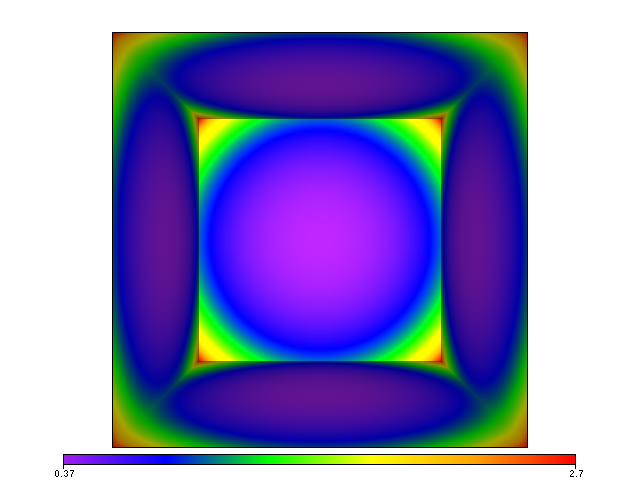

In [8]:
# get eta function from solA and take a look
eta = plt.Figure()
eta.Surface(solA.fn_viscosity,velocityMesh)
eta.show()

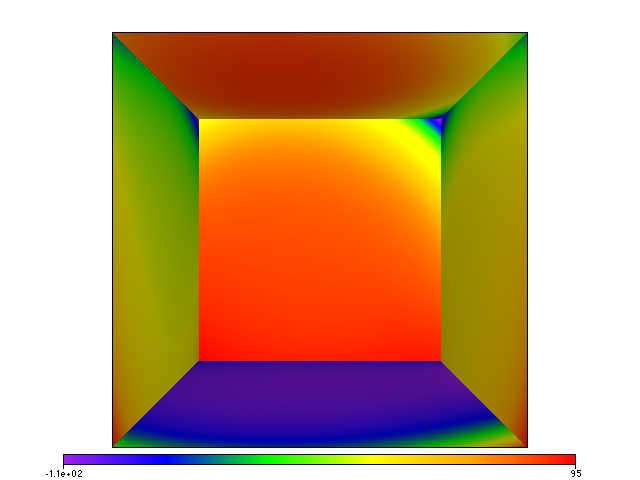

In [9]:
# grab the body force from SolA and take a look at vertical component
force = plt.Figure()
force.Surface(solA.fn_bodyforce[1], velocityMesh)
force.show()

In [11]:
# Get the actual sets 
# Note that we use operator overloading to combine sets
IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]
KWalls = velocityMesh.specialSets["MinK_VertexSet"] + velocityMesh.specialSets["MaxK_VertexSet"]
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
BC = uw.conditions.DirichletCondition( variable=velocityField, 
                                              indexSetsPerDof=(IWalls+JWalls+KWalls,IWalls+JWalls+KWalls,IWalls+JWalls+KWalls) )


In [12]:
# setup our stokes guy
stokesSystem = uw.systems.Stokes(velocityField,pressureField,solA.fn_viscosity,solA.fn_bodyforce,conditions=[BC,], rtolerance=1.e-5)

In [13]:
# lets solve
stokesSystem.solve()

In [14]:
errMesh=uw.mesh.FeMesh_Cartesian('Q1', (16,16,16), (0.,0.,0.), (1.,1.,1.))

appending
periodic=
[False, False, False]
3


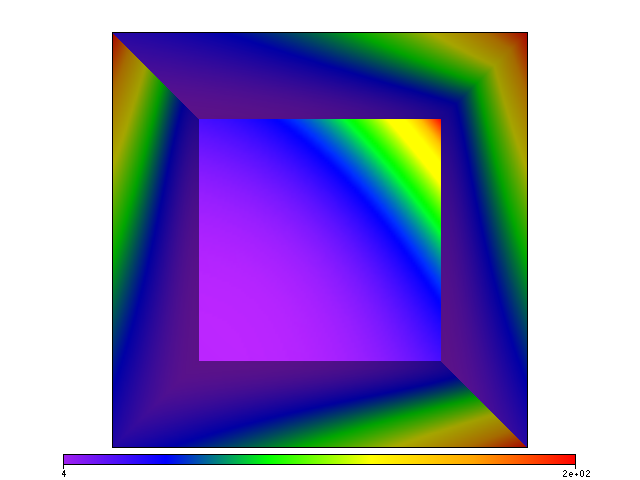

In [15]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), velocityMesh)
velMag.show()

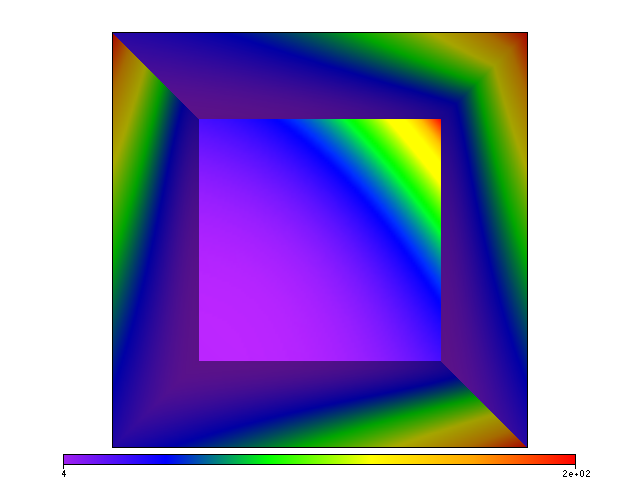

In [16]:
# and analytic
velMagA = plt.Figure()
velMagA.Surface(fn.math.dot(solA.velocityFn,solA.velocityFn), velocityMesh)
velMagA.show()

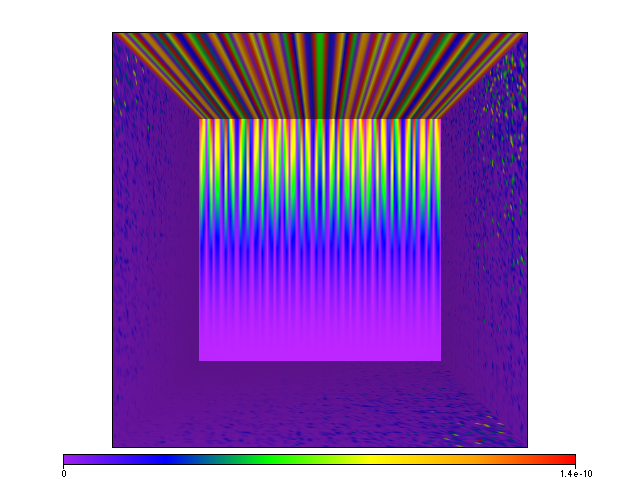

In [17]:
# and difference
velDiff = plt.Figure()
velDiff.Surface(fn.math.dot(solA.velocityFn - velocityField,solA.velocityFn - velocityField), errMesh)
velDiff.show()

In [18]:
# rms
squared = uw.utils.Integral(fn.math.dot(solA.velocityFn-velocityField,solA.velocityFn-velocityField), velocityMesh)
area = uw.utils.Integral(1.,velocityMesh)
math.sqrt(squared.integrate()[0]/area.integrate()[0])

5.0584242085683806e-06

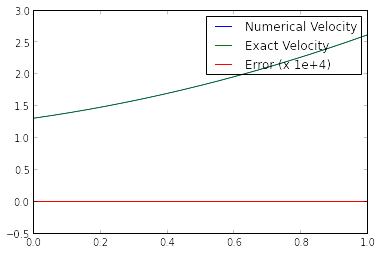

In [19]:
import numpy as np
N=201
a=np.ndarray(shape=(N,2))
a[:,1]=0.75*np.ones(N)
a[:,0]=np.linspace(0,1,N)
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
vy=solA.velocityFn[1].evaluate(a)[:,0]
ax=a[:,0]
vf=velocityField[1].evaluate(a)[:,0]
mplt.plot(ax,vf,label='Numerical Velocity')
mplt.plot(ax,vy,label='Exact Velocity')
mplt.plot(ax,10000*(vy-vf),label='Error (x 1e+4)')
mplt.legend()

In [20]:
ax.shape

(201,)

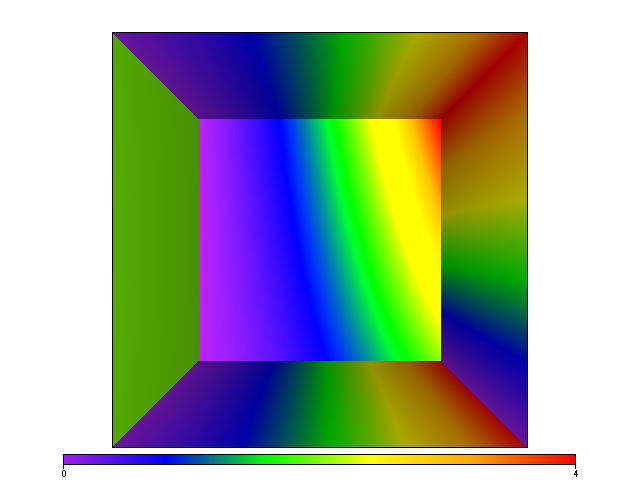

In [21]:
velx = plt.Figure()
velx.Surface(solA.velocityFn[0], velocityMesh)
velx.show()

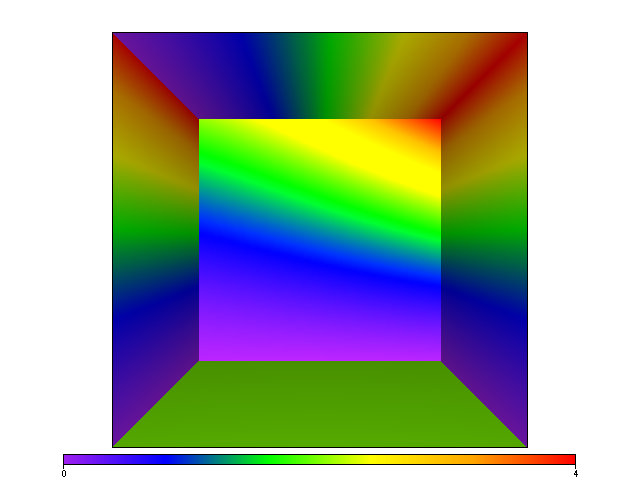

In [22]:
velz = plt.Figure()
velz.Surface(solA.velocityFn[1], velocityMesh)
velz.show()

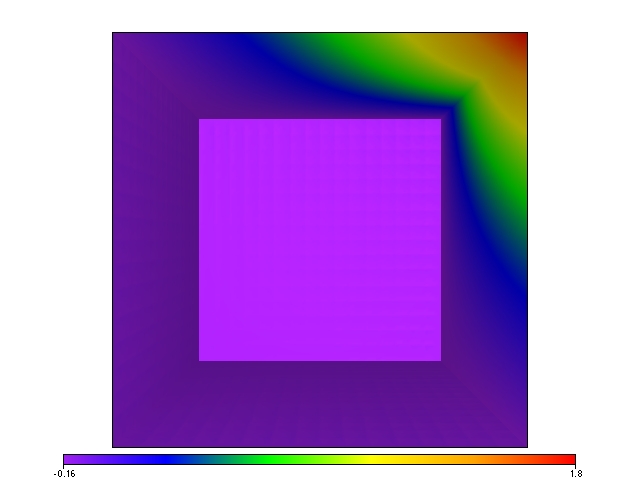

In [23]:
# lets check FEM solution
p = plt.Figure()
p.Surface(pressureField, velocityMesh)
p.show()

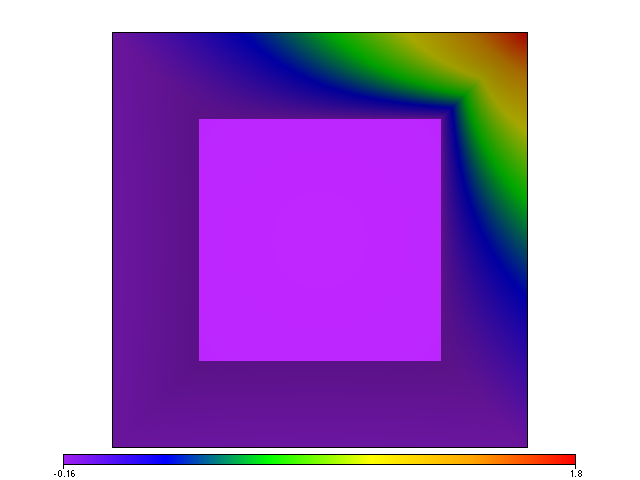

In [24]:
# and analytic
solA=solExact
pA = plt.Figure()
pA.Surface(solA.pressureFn, velocityMesh)
pA.show()

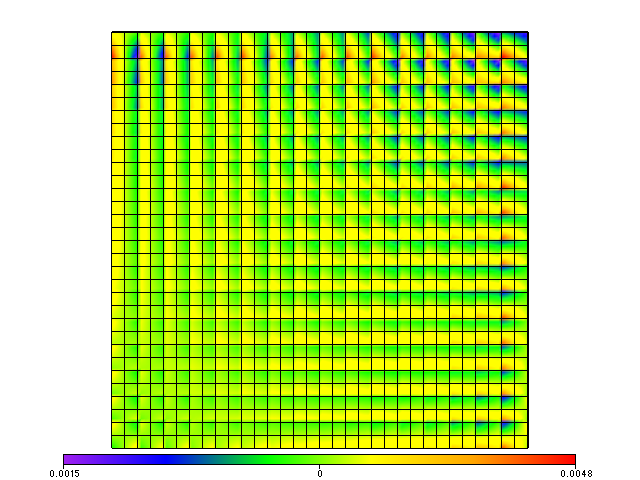

In [25]:
pDiff = plt.Figure()
pDiff.Surface(solA.pressureFn-pressureField, Q1Mesh)
pDiff.Mesh(Q1Mesh)
pDiff.show()

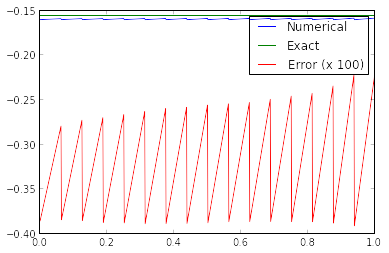

In [26]:
N=801
a=np.ndarray(shape=(N,2))
a[:,0]=0.85*np.ones(N)
a[:,1]=np.linspace(0,1,N)
ax=a[:,1]
pex=solA.pressureFn.evaluate(a)[:,0]
y=a[:,1]
pfd=pressureField.evaluate(a)[:,0]
mplt.plot(y,pfd,label='Numerical')
mplt.plot(y,pex,label='Exact')
mplt.plot(y,100*(pfd-pex),label='Error (x 100)')
#mplt.xlim(0.492,0.496)
#mplt.ylim(-600,-500)
mplt.legend()